In [1]:
import matplotlib.pyplot as plt
import tempfile
import os
import zipfile
import nibabel
from urllib.request import urlretrieve
from skimage import io
from matplotlib import cm


# Create a temporary directory
d = tempfile.mkdtemp()

# Return the tail of the path
os.path.basename('http://google.com/attention.zip')

# Define URL
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip'

# Retrieve the data
fn, info = urlretrieve(url, os.path.join(d, 'attention.zip'))

# Extract the contents into the temporary directory we created earlier
zipfile.ZipFile(fn).extractall(path=d)

# List first 10 files
[f.filename for f in zipfile.ZipFile(fn).filelist[:10]]

# Read the image 
struct = nibabel.load(os.path.join(d, 'attention/structural/nsM00587_0002.hdr'))

# Get a plain NumPy array, without all the metadata
struct_arr = struct.get_data()

struct_arr = io.imread("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/attention-mri.tif")
struct_arr=struct_arr.T

In [48]:
import numpy as np
n_slices=struct_arr.shape[0]
n_images=24
slice_inds=np.floor(np.linspace(0,n_slices-1,n_images)).astype(int)
n_cols=8
n_rows=np.ceil(n_images/n_cols).astype(int)
scale=3

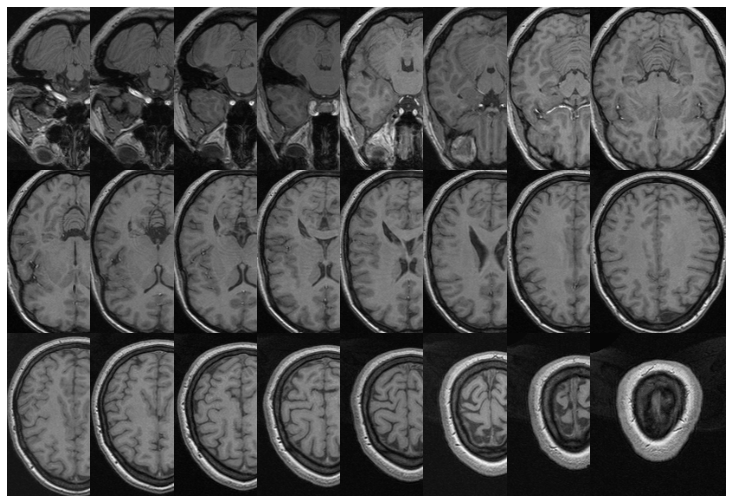

In [49]:
fig,axs=plt.subplots(ncols=n_cols,nrows=n_rows,figsize=(scale*n_cols,scale*n_rows))
axs=axs.ravel()
for i in range(n_images):
    axs[i].imshow(struct_arr[slice_inds[i]],cmap='gray')
    axs[i].axis('off')
fig.subplots_adjust(wspace=-0.89, hspace=0.)
plt.savefig('brain_grid.pdf')  


In [107]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [109]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'q', 'w'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'q':
        previous_slice(ax)
    elif event.key == 'w':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])


In [111]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()

In [112]:
plot_cube(struct_arr[:35,::-1,:25])

NameError: name 'normalize' is not defined

Hello
Hello


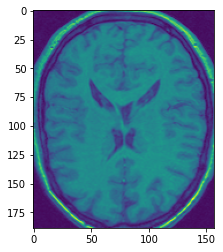

In [110]:
%matplotlib inline
multi_slice_viewer(struct_arr)


In [ ]:
import shutil

# Remove the temporary directory
shutil.rmtree(d)